In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load your dataset (replace the path with your actual file)
df = pd.read_csv('crypto_data.csv')

# Check the first few rows of the df
df.head()

# Step 2: Calculate Log Changes (Log-Returns) for Forecasting
df['Log_Close'] = np.log(df['Close'])

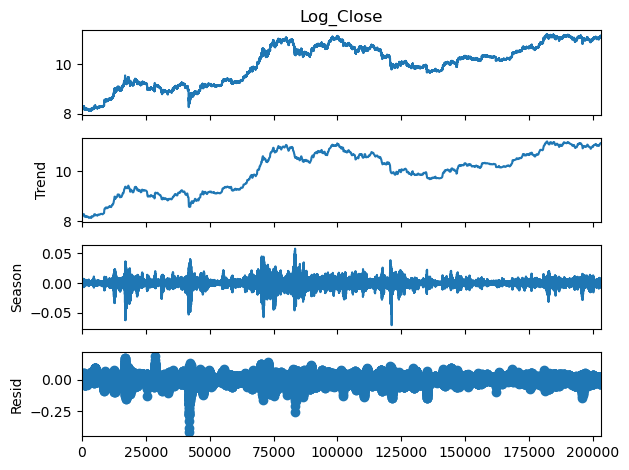

In [20]:
from statsmodels.tsa.seasonal import STL

# Step 3: STL Decomposition
seasonal_period = 96  # 15-minute intervals per day (96 intervals in 24 hours)
stl = STL(df['Log_Close'], period=seasonal_period, robust=True)
result = stl.fit()

# Get the decomposed components
df['STL_Trend'] = result.trend
df['STL_Seasonal'] = result.seasonal
df['STL_Residual'] = result.resid

# Plot the decomposed components
result.plot()
plt.show()


In [21]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,STL_Trend,STL_Seasonal,STL_Residual
0,2019-01-01 00:00:00,3701.23,3703.72,3689.88,3697.31,190.974095,8.215361,8.223030,0.008693,-0.016362
1,2019-01-01 00:15:00,3697.91,3698.75,3690.56,3694.20,131.742721,8.214519,8.223058,0.003783,-0.012322
2,2019-01-01 00:30:00,3693.96,3705.00,3693.00,3702.39,171.877714,8.216734,8.223087,0.002429,-0.008782
3,2019-01-01 00:45:00,3702.05,3713.00,3695.02,3700.31,191.772890,8.216172,8.223116,0.001880,-0.008824
4,2019-01-01 01:00:00,3700.20,3702.73,3691.22,3701.03,139.872706,8.216366,8.223145,0.001995,-0.008774


In [ ]:
# Drop NaN values that may appear due to the diff() operation
df = df.dropna()
# Let's split based on a timestamp, for example:
train_start = '2019-01-02'
train_end = '2024-01-01'
valid_start = '2024-01-02'
valid_end = '2024-04-01'
predict_start = '2024-04-02'
predict_end = '2024-10-20'

# Convert timestamp to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df = df.rename(columns={'Timestamp':})
# Split the df into training, validation, and prediction sets
train_df = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
valid_df = df[(df['Timestamp'] >= valid_start) & (df['Timestamp'] <= valid_end)]
predict_df = df[(df['Timestamp'] >= predict_start) & (df['Timestamp'] <= predict_end)]

# Now train_df, valid_df, predict_df are the respective datasets

In [17]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,STL_Trend,STL_Seasonal,STL_Residual,...,ACF_sum_sq,ACF_2,ACF_3,ACF_4,ACF_5,ACF_6,ACF_7,ACF_8,ACF_9,ACF_10


In [12]:
# Adding features to the data (using the code you already wrote)
lags = [10, 20, 50]
def add_features(df, lags):
    for lag in lags:
        df[f'log_close/mean_{lag}'] = np.log(np.array(df['Close']) /  
                                             np.roll(np.append(np.convolve(np.array(df['Close']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
        df[f'log_return_{lag}'] = np.log(np.array(df['Close']) / np.roll(np.array(df['Close']), lag))

    for lag in lags:
        df[f'mean_close/mean_{lag}'] = np.mean(df.iloc[:, df.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:, df.columns.str.startswith(f'log_return_{lag}')], axis=1)
        
    for lag in lags:
        df[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = np.array(df[f'log_close/mean_{lag}']) - np.array(df[f'mean_close/mean_{lag}'])
        df[f'log_return_{lag}-mean_log_returns_{lag}'] = np.array(df[f'log_return_{lag}']) - np.array(df[f'mean_log_returns_{lag}'])
    return df

# Apply feature engineering to the entire dataset
train_df = add_features(train_df, lags)
valid_df = add_features(valid_df, lags)
predict_df = add_features(predict_df, lags)


ValueError: v cannot be empty

In [ ]:
train_df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,STL_Trend,STL_Seasonal,STL_Residual,...,mean_close/mean_20,mean_log_returns_20,mean_close/mean_50,mean_log_returns_50,log_close/mean_10-mean_close/mean_10,log_return_10-mean_log_returns_10,log_close/mean_20-mean_close/mean_20,log_return_20-mean_log_returns_20,log_close/mean_50-mean_close/mean_50,log_return_50-mean_log_returns_50
5,2019-01-01 01:15:00,3702.39,3702.39,3695.46,3699.25,135.318759,8.215885,8.223175,0.001497,-0.008786,...,8.215885,-2.445438,8.215885,-2.441806,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-01-01 01:30:00,3699.08,3700.00,3689.03,3691.41,140.344071,8.213764,8.223204,0.003062,-0.012503,...,8.213764,-2.447505,8.213764,-2.444624,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-01-01 01:45:00,3691.34,3692.64,3684.22,3689.69,198.003579,8.213298,8.223234,0.001787,-0.011724,...,8.213298,-2.446759,8.213298,-2.445701,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-01-01 02:00:00,3689.67,3695.95,3687.22,3691.67,273.729883,8.213834,8.223265,0.001895,-0.011326,...,8.213834,-2.445212,8.213834,-2.444982,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-01-01 02:15:00,3691.65,3694.71,3675.04,3686.64,245.758540,8.212471,8.223295,0.003953,-0.014777,...,8.212471,-2.446716,8.212471,-2.443104,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
valid_df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,STL_Trend,STL_Seasonal,STL_Residual,...,mean_close/mean_20,mean_log_returns_20,mean_close/mean_50,mean_log_returns_50,log_close/mean_10-mean_close/mean_10,log_return_10-mean_log_returns_10,log_close/mean_20-mean_close/mean_20,log_return_20-mean_log_returns_20,log_close/mean_50-mean_close/mean_50,log_return_50-mean_log_returns_50
175122,2024-01-02 00:00:00,44179.55,44650.00,44148.34,44630.09,2154.59235,10.706164,10.676370,-0.002332,0.032126,...,10.706164,-0.464084,10.706164,-0.455359,0.0,0.0,0.0,0.0,0.0,0.0
175123,2024-01-02 00:15:00,44630.10,44844.00,44450.00,44609.79,1997.62342,10.705709,10.677248,-0.004511,0.032972,...,10.705709,-0.466556,10.705709,-0.458295,0.0,0.0,0.0,0.0,0.0,0.0
175124,2024-01-02 00:30:00,44609.78,44768.29,44553.92,44732.01,1002.64655,10.708445,10.678145,-0.001167,0.031467,...,10.708445,-0.462321,10.708445,-0.453885,0.0,0.0,0.0,0.0,0.0,0.0
175125,2024-01-02 00:45:00,44732.01,45200.00,44677.43,45056.00,1831.39735,10.715661,10.679060,-0.000933,0.037534,...,10.715661,-0.455485,10.715661,-0.446457,0.0,0.0,0.0,0.0,0.0,0.0
175126,2024-01-02 01:00:00,45056.00,45372.79,44841.22,44841.22,2164.10983,10.710883,10.679992,-0.000707,0.031598,...,10.710883,-0.458191,10.710883,-0.452485,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
predict_df.head()

,Timestamp,Open,High,Low,Close,Volume,Log_Close,STL_Trend,STL_Seasonal,STL_Residual,...,mean_close/mean_20,mean_log_returns_20,mean_close/mean_50,mean_log_returns_50,log_close/mean_10-mean_close/mean_10,log_return_10-mean_log_returns_10,log_close/mean_20-mean_close/mean_20,log_return_20-mean_log_returns_20,log_close/mean_50-mean_close/mean_50,log_return_50-mean_log_returns_50
183858,2024-04-02 00:00:00,69649.81,69674.23,69456.66,69577.02,472.62631,11.150190,11.123785,-0.005352,0.031756,...,11.150190,0.019696,11.150190,0.021600,0.0,0.0,0.0,0.0,0.0,0.0
183859,2024-04-02 00:15:00,69577.02,69620.00,69282.19,69410.81,356.43447,11.147798,11.123196,0.003816,0.020787,...,11.147798,0.017745,11.147798,0.017980,0.0,0.0,0.0,0.0,0.0,0.0
183860,2024-04-02 00:30:00,69410.81,69484.00,69040.00,69149.25,450.08981,11.144022,11.122602,0.009403,0.012017,...,11.144022,0.014087,11.144022,0.013747,0.0,0.0,0.0,0.0,0.0,0.0
183861,2024-04-02 00:45:00,69149.25,69414.54,69080.00,69349.08,175.16646,11.146908,11.122006,0.000785,0.024118,...,11.146908,0.016550,11.146908,0.016247,0.0,0.0,0.0,0.0,0.0,0.0
183862,2024-04-02 01:00:00,69349.08,69600.00,69250.00,69506.58,273.14499,11.149177,11.121406,0.004258,0.023512,...,11.149177,0.018460,11.149177,0.018654,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Set up features and target variable
X_train = train_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] +
                   [f'log_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}' for lag in lags] +
                   [f'mean_close/mean_{lag}' for lag in lags] +
                   [f'mean_log_returns_{lag}' for lag in lags] +
                   [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] +
                   [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags]]

y_train = train_df['Log_Change']  # Or use classification targets if applicable

# Train a LightGBM model
params = {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1}
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(params, lgb_train, 100)

# Now we have our trained model


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 175022, number of used features: 20
[LightGBM] [Info] Start training from score 0.000014


In [ ]:
X_predict = predict_df[['Volume', 'Open', 'Close', 'High', 'Low', 'STL_Trend', 'STL_Seasonal', 'STL_Residual'] +
                       [f'log_close/mean_{lag}' for lag in lags] +
                       [f'log_return_{lag}' for lag in lags] +
                       [f'mean_close/mean_{lag}' for lag in lags] +
                       [f'mean_log_returns_{lag}' for lag in lags] +
                       [f'log_close/mean_{lag}-mean_close/mean_{lag}' for lag in lags] +
                       [f'log_return_{lag}-mean_log_returns_{lag}' for lag in lags]]
df_pred = predict_df.copy()
df_pred['Predict'] = lgb_model.predict(X_predict)

100%|██████████| 19297/19297 [00:02<00:00, 7660.52it/s]



Total Trades: 2138
Winning Trades: 24
Losing Trades: 2114
Win Ratio: 1.12%
Total Profit: -100.00%
Max Drawdown: 100.00%

Details of Winning Trades:
                 Timestamp     Close trade_condition trade_result
184474 2024-04-08 10:00:00  71971.99                          Win
186893 2024-05-03 14:45:00  61618.17                          Win
187834 2024-05-13 10:00:00  62769.22                          Win
188053 2024-05-15 16:45:00  64759.27                          Win
188548 2024-05-20 20:30:00  69412.30                          Win
189205 2024-05-27 16:45:00  70161.22                          Win
190736 2024-06-12 15:30:00  69550.01                          Win
193211 2024-07-08 10:15:00  57497.38                          Win
193859 2024-07-15 04:15:00  62589.02                          Win
195565 2024-08-01 22:45:00  65184.37                          Win
195893 2024-08-05 08:45:00  52752.00                          Win
195924 2024-08-05 16:30:00  54643.44                       

ValueError: x and y must have same first dimension, but have shapes (19297,) and (19298,)

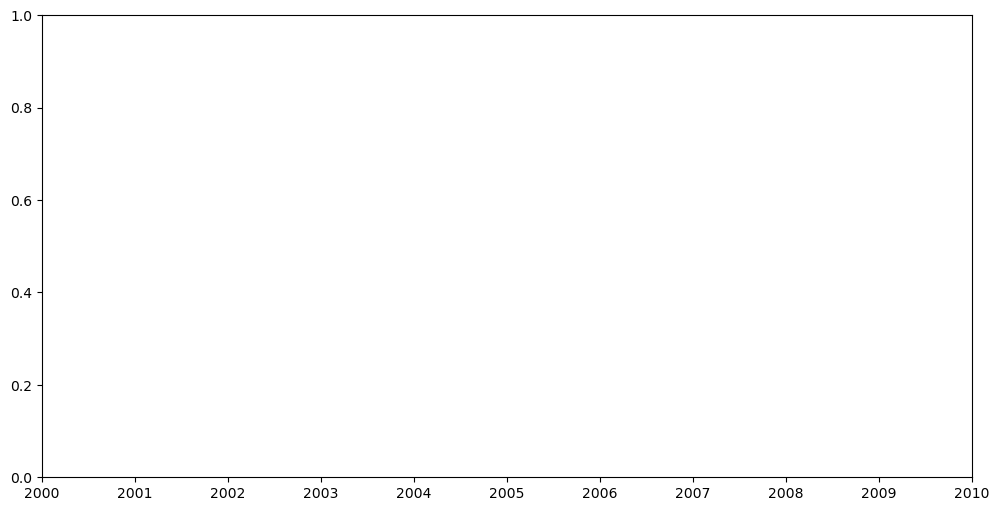

In [ ]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

initial_balance = 100000
trading_balance_ratio = 1
threshold_values = [1e-07]
total_profits = []
drawdowns = []
trade_counts = []
win_ratios = []
average_profits = []

df_pred['position'] = 0  # Add a column for positions
df_pred['trade_result'] = ''  # Track if the trade was a win or loss
df_pred['trade_condition'] = ''  # Track the conditions for the trade

# Backtesting loop
for threshold in threshold_values:
    current_balance = initial_balance
    current_position = 0
    entry_price = 0
    trades = []
    portfolio_values = [initial_balance]
    win_trades = 0
    loss_trades = 0
    peak_balance = initial_balance
    max_drawdown = 0

    for i in tqdm(range(len(df_pred))):
        if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
            # Entry condition for long position
            current_position = 1
            entry_price = df_pred.iloc[i]['Close']
            entry_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = 1
            df_pred.iloc[i, df_pred.columns.get_loc('trade_condition')] = 'Predicted UP - Entered'

        elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
            # Exit condition for long position
            current_position = 0
            exit_price = df_pred.iloc[i]['Close']
            exit_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = -1
            trade_return = (exit_price * 0.99 - entry_price * 1.01) / entry_price * 1.01
            trade_profit = trade_return * min(99000, current_balance)
            current_balance += trade_profit
            trade_duration = exit_time - entry_time
            trades.append((entry_price, entry_time, exit_price, exit_time, trade_return, trade_duration, current_balance))
            
            # Check if the trade is a win or loss
            if trade_profit > 0:
                win_trades += 1
                df_pred.iloc[i, df_pred.columns.get_loc('trade_result')] = 'Win'
            else:
                loss_trades += 1
                df_pred.iloc[i, df_pred.columns.get_loc('trade_result')] = 'Loss'

        portfolio_values.append(current_balance)
        peak_balance = max(peak_balance, current_balance)
        drawdown = (peak_balance - current_balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Final metrics
    total_profit = (current_balance - initial_balance) / initial_balance * 100
    average_profit_per_trade = total_profit / len(trades) if trades else 0
    win_ratio = win_trades / len(trades) if trades else 0

    total_profits.append(total_profit)
    drawdowns.append(max_drawdown)
    trade_counts.append(len(trades))
    win_ratios.append(win_ratio)
    average_profits.append(average_profit_per_trade)

    # Summary Output
    print(f"\nTotal Trades: {len(trades)}")
    print(f"Winning Trades: {win_trades}")
    print(f"Losing Trades: {loss_trades}")
    print(f"Win Ratio: {win_ratio * 100:.2f}%")
    print(f"Total Profit: {total_profit:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    
    # You can also check some of the individual trades' results
    win_trades_details = df_pred[df_pred['trade_result'] == 'Win']
    loss_trades_details = df_pred[df_pred['trade_result'] == 'Loss']
    
    print("\nDetails of Winning Trades:")
    print(win_trades_details[['Timestamp', 'Close', 'trade_condition', 'trade_result']])
    print("\nDetails of Losing Trades:")
    print(loss_trades_details[['Timestamp', 'Close', 'trade_condition', 'trade_result']])

    # Plot the portfolio value over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_pred['Timestamp'], portfolio_values, label='Portfolio Value', color='blue')
    plt.title(f"Backtest Portfolio Value Over Time - Threshold {threshold}")
    plt.xlabel('Timestamp')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Optionally, display the final summary of profits, drawdowns, and win ratios
print("\nFinal Summary of Backtest Results:")
print(f"Total Profit: {total_profits[-1]:.2f}%")
print(f"Max Drawdown: {drawdowns[-1]:.2f}%")
print(f"Average Profit per Trade: {average_profits[-1]:.5f}")
print(f"Win Ratio: {win_ratios[-1] * 100:.2f}%")


100%|██████████| 19297/19297 [00:02<00:00, 7376.45it/s]



Total Trades: 2138
Winning Trades: 24
Losing Trades: 2114
Win Ratio: 1.12%
Total Profit: -100.00%
Max Drawdown: 100.00%

Details of Winning Trades:
                 Timestamp     Close trade_condition trade_result
184474 2024-04-08 10:00:00  71971.99                          Win
186893 2024-05-03 14:45:00  61618.17                          Win
187834 2024-05-13 10:00:00  62769.22                          Win
188053 2024-05-15 16:45:00  64759.27                          Win
188548 2024-05-20 20:30:00  69412.30                          Win
189205 2024-05-27 16:45:00  70161.22                          Win
190736 2024-06-12 15:30:00  69550.01                          Win
193211 2024-07-08 10:15:00  57497.38                          Win
193859 2024-07-15 04:15:00  62589.02                          Win
195565 2024-08-01 22:45:00  65184.37                          Win
195893 2024-08-05 08:45:00  52752.00                          Win
195924 2024-08-05 16:30:00  54643.44                       

ValueError: x and y must have same first dimension, but have shapes (19297,) and (19298,)

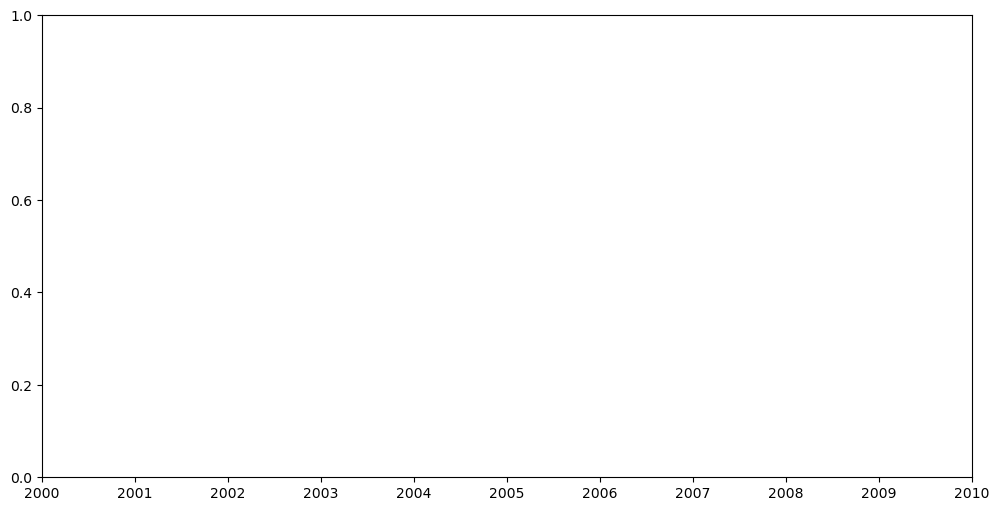

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize backtesting parameters
initial_balance = 100000
trading_balance_ratio = 1
threshold_values = [1e-07]
total_profits = []
drawdowns = []
trade_counts = []
win_ratios = []
average_profits = []

df_pred['position'] = 0  # Add a column for positions

# Backtesting loop
for threshold in threshold_values:
    current_balance = initial_balance
    current_position = 0
    entry_price = 0
    trades = []
    portfolio_values = [initial_balance]
    win_trades = 0
    loss_trades = 0
    peak_balance = initial_balance
    max_drawdown = 0

    for i in tqdm(range(len(df_pred))):
        # Entry condition: open a position if no position is held and the prediction exceeds the threshold
        if current_position == 0 and df_pred.iloc[i]['Predict'] > threshold:
            current_position = 1
            entry_price = df_pred.iloc[i]['Close']
            entry_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = 1

        # Exit condition: close the position if the prediction is less than 0
        elif current_position == 1 and df_pred.iloc[i]['Predict'] < 0:
            current_position = 0
            exit_price = df_pred.iloc[i]['Close']
            exit_time = df_pred.iloc[i]['Timestamp']
            df_pred.iloc[i, df_pred.columns.get_loc('position')] = -1
            
            # Adjusted trade return calculation with slippage
            trade_return = (exit_price * 0.99 - entry_price * 1.01) / (entry_price * 1.01)
            trade_profit = trade_return * min(99000, current_balance)
            current_balance += trade_profit
            
            # Calculate trade duration in minutes
            trade_duration = (exit_time - entry_time).total_seconds() / 60  # Time in minutes
            trades.append((entry_price, entry_time, exit_price, exit_time, trade_return, trade_duration, current_balance))
            
            # Track wins and losses
            if trade_profit > 0:
                win_trades += 1
            else:
                loss_trades += 1

        # Track portfolio value
        portfolio_values.append(current_balance)
        peak_balance = max(peak_balance, current_balance)
        drawdown = (peak_balance - current_balance) / peak_balance * 100
        max_drawdown = max(max_drawdown, drawdown)

    # Calculate key metrics
    total_profit = (current_balance - initial_balance) / initial_balance * 100
    average_profit_per_trade = total_profit / len(trades) if trades else 0
    win_ratio = win_trades / len(trades) if trades else 0

    total_profits.append(total_profit)
    drawdowns.append(max_drawdown)
    trade_counts.append(len(trades))
    win_ratios.append(win_ratio)
    average_profits.append(average_profit_per_trade)

# Displaying final performance summary
print(f'Total Profits: {total_profits[-1]:.2f}%')
print(f'Max Drawdown: {drawdowns[-1]:.2f}%')
print(f'Trade Count: {trade_counts[-1]}')
print(f'Win Ratio: {win_ratios[-1]:.2f}')
print(f'Average Profit per Trade: {average_profits[-1]:.4f}%')

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

# Plot drawdown over time
plt.figure(figsize=(10, 6))
drawdown_values = [peak_balance - value for value in portfolio_values]
plt.plot(drawdown_values, label='Drawdown ($)')
plt.xlabel('Time')
plt.ylabel('Drawdown ($)')
plt.title('Drawdown Over Time')
plt.legend()
plt.show()


In [ ]:
print("Tổng phần trăm lãi:", total_profits[0])
print("Max Drawdown:", drawdowns[0])
print("Số lượng giao dịch", trade_counts[0])
print("Tỉ lệ giao dịch có lãi:", win_ratios[0])
print("Phần trăm lãi trung bình 1 giao dịch:", average_profits[0])

Tổng phần trăm lãi: -100.0
Max Drawdown: 100.0
Số lượng giao dịch 2138
Tỉ lệ giao dịch có lãi: 0.011225444340505144
Phần trăm lãi trung bình 1 giao dịch: -0.04677268475210477
